## Import Libaries
- 

In [2]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
import cv2
import os
import glob

from random import sample, randint

from sklearn.model_selection import train_test_split

from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Dropout
from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import VGG16
from keras.applications.resnet_v2 import ResNet50V2

import easyocr

from lxml import etree

## Chargement du Dataset (Load Dataset)
Le Dataset contient 
- Les annotations sont des fichiers xml, qui contient les coordonnées des regions intérêt sur les images (les étiquettes) 
- Les differentes images des plaques d'immatriculations


In [3]:
#parcourir les fichiers images et dataset
src_path = "../dataset/input"
for dirName, _, fileNames in os.walk(src_path):
    for fileName in fileNames:
        print(os.path.join(dirName, fileName))

../dataset/input\annotations\Cars0.xml
../dataset/input\annotations\Cars1.xml
../dataset/input\annotations\Cars10.xml
../dataset/input\annotations\Cars100.xml
../dataset/input\annotations\Cars101.xml
../dataset/input\annotations\Cars102.xml
../dataset/input\annotations\Cars103.xml
../dataset/input\annotations\Cars104.xml
../dataset/input\annotations\Cars105.xml
../dataset/input\annotations\Cars106.xml
../dataset/input\annotations\Cars107.xml
../dataset/input\annotations\Cars108.xml
../dataset/input\annotations\Cars109.xml
../dataset/input\annotations\Cars11.xml
../dataset/input\annotations\Cars110.xml
../dataset/input\annotations\Cars111.xml
../dataset/input\annotations\Cars112.xml
../dataset/input\annotations\Cars113.xml
../dataset/input\annotations\Cars114.xml
../dataset/input\annotations\Cars115.xml
../dataset/input\annotations\Cars116.xml
../dataset/input\annotations\Cars117.xml
../dataset/input\annotations\Cars118.xml
../dataset/input\annotations\Cars119.xml
../dataset/input\annot

## Extraction
Extraire les informations
- Les images seront stocker dans une liste `X` 
- Les coordonnées seront extrait des annotations (étiquettes) et stocker dans un vecteur `y = [vx,vy]`

|  vx  |  vy  |
|------|------|
| xmin | ymin |
| xmax | ymax | 


#### Extraction d'images

In [31]:
# Définir taille d'image 
IMAGE_SIZE = 200

img_dir = src_path + "/images" ##"../input/car-plate-detection/images"
data_path = os.path.join(img_dir,'*g') # all files end with ...g (png, jpg, )
files = glob.glob(data_path)
files.sort()

X=[] # List des
for f1 in files:
    img = cv2.imread(f1)
    img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE))
    X.append(np.array(img))

#### Extraction des coordonnées (dans les annotations)

In [5]:
def resizeannotation(f):  # Fonction qui va extraire les informations des fichiers xml
    tree = etree.parse(f)
    for dim in tree.xpath("size"):
        width = int(dim.xpath("width")[0].text)
        height = int(dim.xpath("height")[0].text)
    for dim in tree.xpath("object/bndbox"):
        xmin = int(dim.xpath("xmin")[0].text) / (width / IMAGE_SIZE)
        ymin = int(dim.xpath("ymin")[0].text) / (height / IMAGE_SIZE)
        xmax = int(dim.xpath("xmax")[0].text) / (width / IMAGE_SIZE)
        ymax = int(dim.xpath("ymax")[0].text) / (height / IMAGE_SIZE)
    return [int(xmax), int(ymax), int(xmin), int(ymin)]

In [6]:
path = src_path + '/annotations'
text_files = [src_path + '/annotations/'+f for f in sorted(os.listdir(path))] # Stocker les fichiers xml dans la liste

y=[] # List des coordonnées des regions intérêt
for i in text_files:
    y.append(resizeannotation(i))

## Afficher les images du dataset (Display Image Dataset)

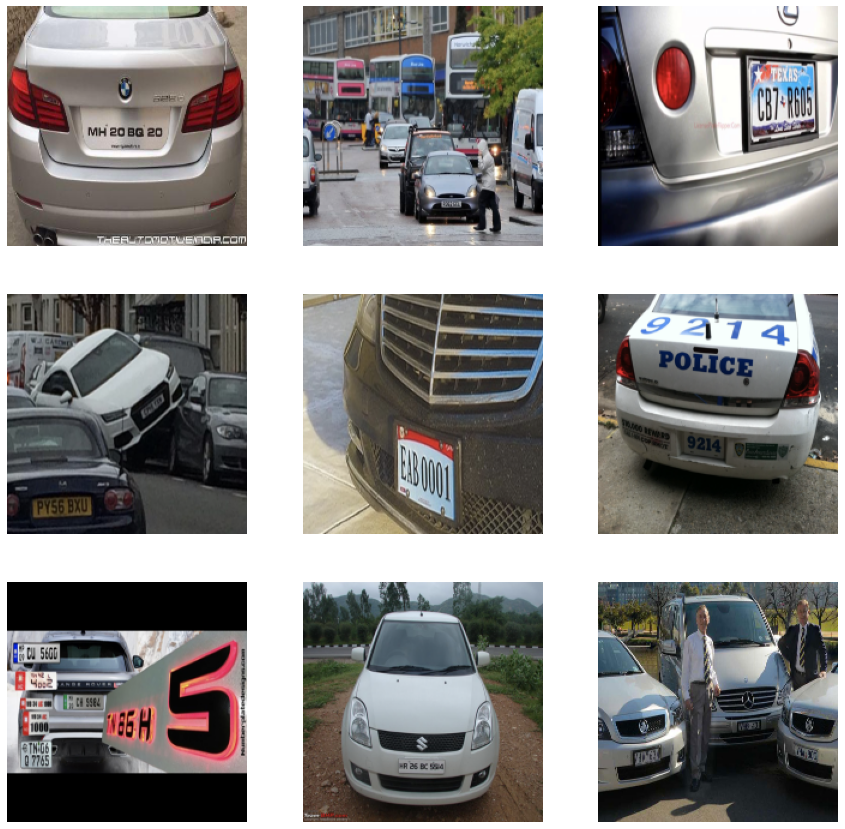

In [8]:
sample_index = []

for i in range(9):
    sample_index.append(randint(0, len(X)))

plt.figure(figsize=(15, 15))
for index, i in enumerate(sample_index):
    plt.subplot(3, 3, index + 1)
    plt.axis('off')
    plt.imshow(cv2.cvtColor(X[i], cv2.COLOR_BGR2RGB))

## Verifier la taille des images

In [9]:
print(f"X Shape : {np.array(X).shape}")
print(f"y Shape : {np.array(y).shape}")

X Shape : (433, 200, 200, 3)
y Shape : (433, 4)


## Afficher les images du dataset avec leurs annotations (région d'interêt) 

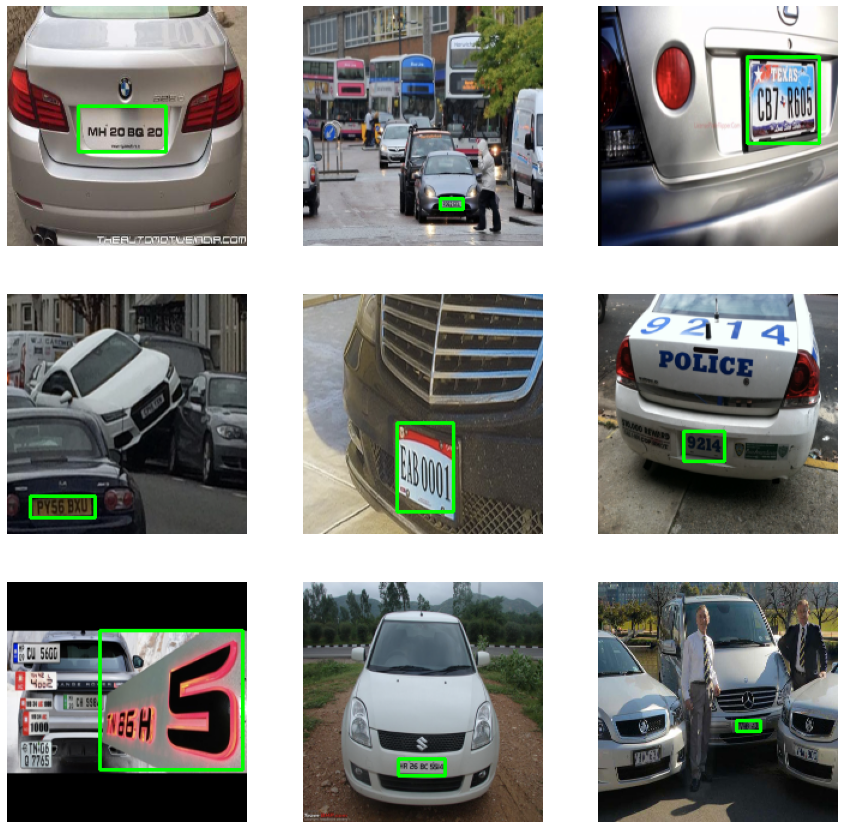

In [10]:
plt.figure(figsize=(15, 15))
for index, i in enumerate(sample_index):
    plt.subplot(3, 3, index + 1)
    image = cv2.rectangle(cv2.cvtColor(X[i], cv2.COLOR_BGR2RGB),(y[i][0],y[i][1]),(y[i][2],y[i][3]),(0, 255, 0), 2)
    plt.imshow(image)
    plt.axis("off")

plt.show()

In [11]:
for i in range(9):
    print(y[i])

[167, 129, 90, 93]
[131, 129, 67, 103]
[151, 131, 70, 4]
[107, 98, 87, 85]
[120, 146, 83, 134]
[184, 151, 37, 111]
[101, 123, 94, 118]
[97, 150, 78, 142]
[103, 132, 76, 122]


## Prétraitement des données (Data Preprocessing)

AttributeError: 'list' object has no attribute 'shape'

In [41]:
X = np.array(X)
y = np.array(y)

X = X / 255 # reduire les valeurs des X en valuer comprise entre 0.0 et 1.0 | pour être utilisé on multipliera par 255
y = y / 255 # reduire les valeurs de y 

In [51]:
X.shape

array([[[[0.55686275, 0.45098039, 0.23529412],
         [0.63529412, 0.49803922, 0.18431373],
         [0.67843137, 0.57647059, 0.35294118],
         ...,
         [0.14901961, 0.15294118, 0.14901961],
         [0.17254902, 0.16862745, 0.16470588],
         [0.14509804, 0.14117647, 0.13333333]],

        [[0.51764706, 0.43137255, 0.22745098],
         [0.60784314, 0.4745098 , 0.16078431],
         [0.55294118, 0.45882353, 0.25490196],
         ...,
         [0.19215686, 0.19607843, 0.19607843],
         [0.18039216, 0.18431373, 0.17254902],
         [0.14117647, 0.14901961, 0.1372549 ]],

        [[0.51764706, 0.44705882, 0.27058824],
         [0.60392157, 0.48235294, 0.17647059],
         [0.56470588, 0.49411765, 0.31372549],
         ...,
         [0.15294118, 0.15294118, 0.15686275],
         [0.19607843, 0.19215686, 0.18039216],
         [0.14117647, 0.14509804, 0.12941176]],

        ...,

        [[0.15294118, 0.18431373, 0.2745098 ],
         [0.15686275, 0.18823529, 0.27843137]

<font size="3">Fractionnement des l'ensemble des données : (70% Entrainement, 10% Validation, 20% Testes) | Data Splitting (70% Training, 10% Validation, 20% Testing)</font>

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # Test : 20%
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=1) # Validation : 10%

In [48]:
X_test.shape

(87, 200, 200, 3)

## Implémentation du modèle VGG19

In [14]:
model = Sequential()
model.add(VGG16(weights="imagenet", include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))

model.add(Flatten())
model.add(Dropout(0.4))
model.add(Dense(256, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(64,  activation="relu"))
model.add(Dense(4,   activation="sigmoid"))

model.layers[-7].trainable = False

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 6, 6, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 18432)             0         
                                                                 
 dropout (Dropout)           (None, 18432)             0         
                                                                 
 dense (Dense)               (None, 256)               4718848   
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 4)                 2

## Entrainement du modèle VGG19, 

#### Loss fonction : MSE (mean square error)
#### Optimizer : ADAM (a gradiant descent stochastic)


In [15]:
import keras.optimizers as  optimizers


In [16]:
optimizer = optimizers.Adam()
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=32, verbose=1)

Epoch 1/30
10/10 [==============================] - 52s 5s/step - loss: 0.0483 - accuracy: 0.2881 - val_loss: 0.0288 - val_accuracy: 0.5000
Epoch 2/30
10/10 [==============================] - 54s 5s/step - loss: 0.0159 - accuracy: 0.5993 - val_loss: 0.0185 - val_accuracy: 0.6136
Epoch 3/30
10/10 [==============================] - 51s 5s/step - loss: 0.0111 - accuracy: 0.6325 - val_loss: 0.0116 - val_accuracy: 0.7500
Epoch 4/30
10/10 [==============================] - 53s 5s/step - loss: 0.0065 - accuracy: 0.7517 - val_loss: 0.0113 - val_accuracy: 0.7045
Epoch 5/30
10/10 [==============================] - 57s 6s/step - loss: 0.0047 - accuracy: 0.8013 - val_loss: 0.0104 - val_accuracy: 0.7273
Epoch 6/30
10/10 [==============================] - 55s 5s/step - loss: 0.0030 - accuracy: 0.8311 - val_loss: 0.0113 - val_accuracy: 0.7955
Epoch 7/30
10/10 [==============================] - 51s 5s/step - loss: 0.0023 - accuracy: 0.8179 - val_loss: 0.0117 - val_accuracy: 0.7955
Epoch 8/30
10/10 [==

In [21]:
model.save('_adam/vgg16_trained_model_adam.h5')

## Evaluation 

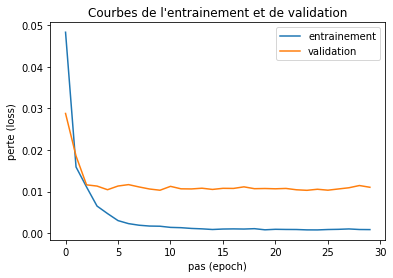

In [17]:
#plt.plot(range(1, len(ada.cost_) + 1), ada.cost_, marker='o')

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Courbes de l\'entrainement et de validation') #('Training and validation loss curves (VGG19)')
plt.ylabel('perte (loss)')
plt.xlabel('pas (epoch)')
plt.legend(['entrainement', 'validation'], loc='upper right')
plt.show()

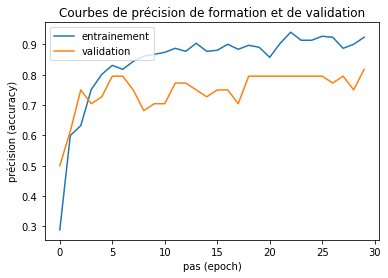

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Courbes de précision de formation et de validation') # ('Training and validation accuracy curves (VGG19)')
plt.ylabel('précision (accuracy)')
plt.xlabel('pas (epoch)')
plt.legend(['entrainement', 'validation'], loc='upper left')
plt.show()

## Teste du VGG19

In [19]:
test_loss, test_accuracy = model.evaluate(X_test, y_test,steps=int(100))
y_cnn = model.predict(X_test)

print("")
print(f"Loss : {test_loss * 100}%")
print(f"Accuracy : {test_accuracy * 100}%")

3/3 [==============================] - 12s 4s/step

Loss : 0.5263925064355135%
Accuracy : 83.90804529190063%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


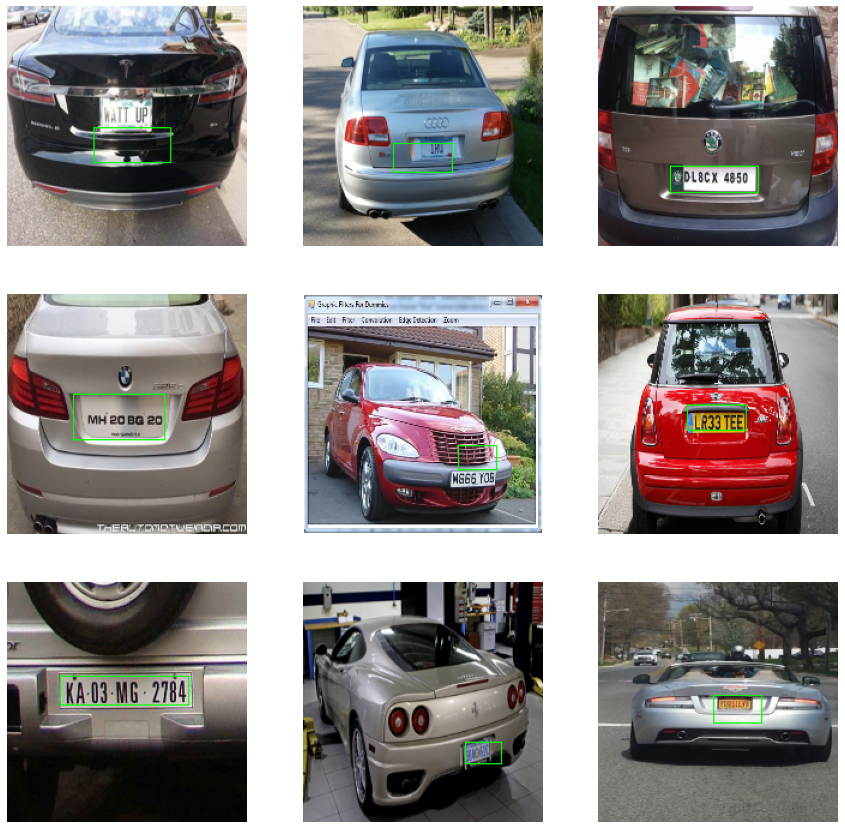

In [20]:
sample_index = []

img_list = []
for i in range(9):
    sample_index.append(randint(0, len(X_test)))

#text = easyocr.Reader(['en'])
plt.figure(figsize=(15, 15))
for index, i in enumerate(sample_index):
    plt.subplot(3, 3, index + 1)
    plt.axis('off')
    ny = np.copy(y_cnn[i])
    ny = ny * 255
    
    rgb_img = cv2.cvtColor(np.copy(X_test[i]).astype('float32'), cv2.COLOR_BGR2RGB)
    image = cv2.rectangle(rgb_img,(int(ny[0]),int(ny[1])),(int(ny[2]),int(ny[3])),(0, 255, 0))
    img_list.append(image)
    plt.imshow(image)
    
plt.show()

In [53]:
# Définir taille d'image 
IMAGE_SIZE = 200

img_dir = "../dataset/cd_test"
data_path = os.path.join(img_dir,'*g') # all files end with ...g (png, jpg, )
files = glob.glob(data_path)
files.sort()

plates=[] # List des
for f1 in files:
    img = cv2.imread(f1)
    img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE))
    plates.append(np.array(img))

# FIN du code


### La suite 
Juste après aussi implémenter le VGG16 pour voir ses performances équivalent VGG19.

Enfin faire l’étude comparative de différent optimiseur : ADAM, ADADELTA, NAG, Momentum, RMSprop,